# Regression Model

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Stef0916/chemoinformatics-bioinformatics/blob/main/acetylcholinesterase-QSAR/notebooks/4.3-Data-bias-ML-algorithm.ipynb)

## 1. Import Libraries

In [1]:
!pip install rdkit-pypi

In [2]:
!pip install openpyxl

In [3]:
!pip install cairosvg

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw #2D depiction
from rdkit.Chem import rdDepictor #2D coordinate generation, consistency

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

## Load Data

In [5]:
descriptors_train = pd.read_csv('/content/reduced_descriptors_train.csv')

In [6]:
descriptors_train = descriptors_train.set_index('molecule_chembl_id')

In [7]:
descriptors_train.head()

,nAcid,nBase,VE1_A,nSpiro,nBridgehead,nB,AATS4i,ATSC5dv,ATSC6dv,ATSC8dv,...,n9FAHRing,JGI2,JGI3,JGI4,JGI5,JGI6,JGI7,JGI8,JGI9,JGI10
molecule_chembl_id,,,,,,,,,,,,,,,,,,,,,
CHEMBL4468781,0,0,3.960664,0,0,0,159.496714,-111.776025,-119.364540,44.303612,...,0,0.065134,0.047814,0.039922,0.023478,0.016611,0.010863,0.008414,0.006963,0.007337
CHEMBL199670,0,0,3.793369,0,0,0,160.711564,-120.228923,-52.724063,-5.502876,...,0,0.064103,0.039701,0.029409,0.014824,0.011958,0.009629,0.005465,0.004549,0.004576
CHEMBL199861,0,0,3.799305,0,0,0,160.526614,-128.211073,-53.930796,16.979239,...,0,0.065359,0.040465,0.030048,0.015194,0.012290,0.008953,0.005660,0.006030,0.006247
CHEMBL4556734,0,0,3.790319,0,0,0,160.879353,-112.971512,-48.011687,-24.083272,...,0,0.062893,0.038966,0.028796,0.014471,0.011643,0.009345,0.006106,0.004386,0.003304
CHEMBL199585,0,0,3.955743,0,0,0,160.357118,-116.818679,-61.872742,-20.925938,...,0,0.063492,0.049210,0.034897,0.021214,0.015529,0.011971,0.007134,0.005614,0.004839


In [8]:
descriptors_train.shape

(3953, 241)

In [9]:
descriptors_test = pd.read_csv('/content/reduced_descriptors_test.csv')

In [10]:
descriptors_test.shape

(1510, 242)

In [11]:
descriptors_test = descriptors_test.set_index('molecule_chembl_id')

In [12]:
descriptors_test.head()

,nAcid,nBase,VE1_A,nSpiro,nBridgehead,nB,AATS4i,ATSC5dv,ATSC6dv,ATSC8dv,...,n9FAHRing,JGI2,JGI3,JGI4,JGI5,JGI6,JGI7,JGI8,JGI9,JGI10
molecule_chembl_id,,,,,,,,,,,,,,,,,,,,,
CHEMBL4469239,0,0,3.799305,0,0,0,159.102807,-109.399846,-64.755863,5.191465,...,0,0.065359,0.040465,0.030048,0.015194,0.012290,0.008953,0.005660,0.006030,0.006247
CHEMBL4780352,0,1,4.249602,0,0,0,157.417355,61.824490,47.841633,24.553469,...,0,0.076628,0.045326,0.038862,0.032870,0.018058,0.010193,0.011732,0.006769,0.005921
CHEMBL4467284,0,0,3.790319,0,0,0,159.587651,-96.849444,-60.687931,-18.428537,...,0,0.062893,0.038966,0.028796,0.014471,0.011643,0.009345,0.006106,0.004386,0.003304
CHEMBL3585776,0,0,4.184739,0,0,0,161.647762,20.078793,-45.908093,17.976626,...,0,0.076190,0.051136,0.039140,0.031893,0.018957,0.016806,0.009540,0.009375,0.006061
CHEMBL3585775,0,0,4.071157,0,0,0,161.399647,-57.911166,52.457284,-68.223539,...,0,0.076190,0.060662,0.035686,0.031609,0.019738,0.014957,0.009226,0.007674,0.006494


In [13]:
Train = PandasTools.LoadSDF('/content/molecules_train.sdf', molColName='Molecule')

In [14]:
Train.drop(['Murcko Scaffold', '#Atoms MS', 'Cluster'], axis=1, inplace=True)

In [15]:
Train = Train.set_index('molecule_chembl_id')

In [16]:
Train.head()

,curated_smiles,class,Label,pIC50,ID,Molecule
molecule_chembl_id,,,,,,
CHEMBL4468781,COc1ccc2[nH]cc(CCNC(=O)CCCCCNc3c4c(nc5cc(Cl)cc...,active,1,5.30103,,<rdkit.Chem.rdchem.Mol object at 0x7c5e951d3840>
CHEMBL199670,O=C(CCCCCCNc1c2c(nc3ccccc13)CCCC2)NCCc1c[nH]c2...,active,1,5.30103,,<rdkit.Chem.rdchem.Mol object at 0x7c5e951d38b0>
CHEMBL199861,O=C(CCCCCNc1c2c(nc3ccccc13)CCCC2)NCCc1c[nH]c2c...,active,1,5.30103,,<rdkit.Chem.rdchem.Mol object at 0x7c5e951d3990>
CHEMBL4556734,O=C(CCCCCCCNc1c2c(nc3ccccc13)CCCC2)NCCc1c[nH]c...,active,1,5.30103,,<rdkit.Chem.rdchem.Mol object at 0x7c5e951d3ae0>
CHEMBL199585,O=C(CCCCCCNc1c2c(nc3cc(Cl)cc(Cl)c13)CCCC2)NCCc...,active,1,5.30103,,<rdkit.Chem.rdchem.Mol object at 0x7c5e951d3c30>


In [17]:
test = PandasTools.LoadSDF('/content/molecules_test.sdf', molColName='Molecule')

In [18]:
test.drop(['Murcko Scaffold', '#Atoms MS', 'Cluster'], axis=1, inplace=True)

In [19]:
test = test.set_index('molecule_chembl_id')

In [20]:
test.head()

,curated_smiles,class,Label,pIC50,ID,Molecule
molecule_chembl_id,,,,,,
CHEMBL4469239,S=C(CCCCCNc1c2c(nc3ccccc13)CCCC2)NCCc1c[nH]c2c...,active,1,5.30103,,<rdkit.Chem.rdchem.Mol object at 0x7c5e9493a7a0>
CHEMBL4780352,COc1cc2c(cc1OC)C(=O)C(=Cc1ccc(OCCCCN[N+]3(C)CC...,active,1,5.30103,,<rdkit.Chem.rdchem.Mol object at 0x7c5e9493aa40>
CHEMBL4467284,S=C(CCCCCCCNc1c2c(nc3ccccc13)CCCC2)NCCc1c[nH]c...,active,1,5.30103,,<rdkit.Chem.rdchem.Mol object at 0x7c5e9493a500>
CHEMBL3585776,COc1ccc(C(C)NS(=O)(=O)NC(=O)OCc2ccccc2)cc1,active,1,1.571056,,<rdkit.Chem.rdchem.Mol object at 0x7c5e9493af80>
CHEMBL3585775,COc1ccccc1C(C)NS(=O)(=O)NC(=O)OCc1ccccc1,active,1,1.571056,,<rdkit.Chem.rdchem.Mol object at 0x7c5e94939fc0>


In [21]:
Train['Label'] = Train['Label'].astype('int')

In [22]:
Train['pIC50'] = Train['pIC50'].astype('float64')

In [23]:
test['Label'] = test['Label'].astype('int')

In [24]:
test['pIC50'] = test['pIC50'].astype('float64')

In [25]:
# Compare if the indexes are the same
indexes_are_equal = descriptors_train.index.equals(Train.index)

print(indexes_are_equal)

True


In [26]:
indexes_are_equal = descriptors_test.index.equals(test.index)

print(indexes_are_equal)

True


In [27]:
combined_train = pd.concat([Train[['Label', 'pIC50']], descriptors_train], axis=1)

In [28]:
combined_train.head()

,Label,pIC50,nAcid,nBase,VE1_A,nSpiro,nBridgehead,nB,AATS4i,ATSC5dv,...,n9FAHRing,JGI2,JGI3,JGI4,JGI5,JGI6,JGI7,JGI8,JGI9,JGI10
molecule_chembl_id,,,,,,,,,,,,,,,,,,,,,
CHEMBL4468781,1,5.30103,0,0,3.960664,0,0,0,159.496714,-111.776025,...,0,0.065134,0.047814,0.039922,0.023478,0.016611,0.010863,0.008414,0.006963,0.007337
CHEMBL199670,1,5.30103,0,0,3.793369,0,0,0,160.711564,-120.228923,...,0,0.064103,0.039701,0.029409,0.014824,0.011958,0.009629,0.005465,0.004549,0.004576
CHEMBL199861,1,5.30103,0,0,3.799305,0,0,0,160.526614,-128.211073,...,0,0.065359,0.040465,0.030048,0.015194,0.012290,0.008953,0.005660,0.006030,0.006247
CHEMBL4556734,1,5.30103,0,0,3.790319,0,0,0,160.879353,-112.971512,...,0,0.062893,0.038966,0.028796,0.014471,0.011643,0.009345,0.006106,0.004386,0.003304
CHEMBL199585,1,5.30103,0,0,3.955743,0,0,0,160.357118,-116.818679,...,0,0.063492,0.049210,0.034897,0.021214,0.015529,0.011971,0.007134,0.005614,0.004839


In [29]:
combined_test = pd.concat([test[['Label', 'pIC50']], descriptors_test], axis=1)

In [30]:
combined_test.head()

,Label,pIC50,nAcid,nBase,VE1_A,nSpiro,nBridgehead,nB,AATS4i,ATSC5dv,...,n9FAHRing,JGI2,JGI3,JGI4,JGI5,JGI6,JGI7,JGI8,JGI9,JGI10
molecule_chembl_id,,,,,,,,,,,,,,,,,,,,,
CHEMBL4469239,1,5.301030,0,0,3.799305,0,0,0,159.102807,-109.399846,...,0,0.065359,0.040465,0.030048,0.015194,0.012290,0.008953,0.005660,0.006030,0.006247
CHEMBL4780352,1,5.301030,0,1,4.249602,0,0,0,157.417355,61.824490,...,0,0.076628,0.045326,0.038862,0.032870,0.018058,0.010193,0.011732,0.006769,0.005921
CHEMBL4467284,1,5.301030,0,0,3.790319,0,0,0,159.587651,-96.849444,...,0,0.062893,0.038966,0.028796,0.014471,0.011643,0.009345,0.006106,0.004386,0.003304
CHEMBL3585776,1,1.571056,0,0,4.184739,0,0,0,161.647762,20.078793,...,0,0.076190,0.051136,0.039140,0.031893,0.018957,0.016806,0.009540,0.009375,0.006061
CHEMBL3585775,1,1.571056,0,0,4.071157,0,0,0,161.399647,-57.911166,...,0,0.076190,0.060662,0.035686,0.031609,0.019738,0.014957,0.009226,0.007674,0.006494


In [31]:
combined_train.to_csv('combined_train.csv', index=True)
combined_test.to_csv('combined_test.ces', index=True)

## Data Scaling

**Scale pIC50**


---


In [32]:
pic50_scaler = StandardScaler()
scaled_pic50_train = pic50_scaler.fit_transform(combined_train[['pIC50']])
scaled_pic50_test = pic50_scaler.transform(combined_test[['pIC50']])

In [33]:
scaled_pic50_train_df = pd.DataFrame(scaled_pic50_train, columns=['pIC50'])
scaled_pic50_train_df

,pIC50
0,5.096115
1,5.096115
2,5.096115
3,5.096115
4,5.096115
...,...
3948,-2.305898
3949,-2.340977
3950,-2.461564
3951,-2.571880


In [34]:
scaled_pic50_test_df = pd.DataFrame(scaled_pic50_test, columns=['pIC50'])
scaled_pic50_test_df

,pIC50
0,5.096115
1,5.096115
2,5.096115
3,2.804441
4,2.804441
...,...
1505,-2.321545
1506,-2.406269
1507,-2.449278
1508,-2.500886


In [35]:
scaled_pic50_train_df_id = scaled_pic50_train_df.set_index(combined_train.index)

In [36]:
scaled_pic50_test_df_id = scaled_pic50_test_df.set_index(combined_test.index)

In [37]:
scaled_pic50_train_df_id.to_csv('pIC50_train_scaled.csv', index=True)

In [38]:
scaled_pic50_test_df_id.to_csv('pIC50_test_scaled.csv', index=True)

**Train set**


---


In [39]:
# Initialize the scaler
scaler = StandardScaler()

In [40]:
combined_train.head()

,Label,pIC50,nAcid,nBase,VE1_A,nSpiro,nBridgehead,nB,AATS4i,ATSC5dv,...,n9FAHRing,JGI2,JGI3,JGI4,JGI5,JGI6,JGI7,JGI8,JGI9,JGI10
molecule_chembl_id,,,,,,,,,,,,,,,,,,,,,
CHEMBL4468781,1,5.30103,0,0,3.960664,0,0,0,159.496714,-111.776025,...,0,0.065134,0.047814,0.039922,0.023478,0.016611,0.010863,0.008414,0.006963,0.007337
CHEMBL199670,1,5.30103,0,0,3.793369,0,0,0,160.711564,-120.228923,...,0,0.064103,0.039701,0.029409,0.014824,0.011958,0.009629,0.005465,0.004549,0.004576
CHEMBL199861,1,5.30103,0,0,3.799305,0,0,0,160.526614,-128.211073,...,0,0.065359,0.040465,0.030048,0.015194,0.012290,0.008953,0.005660,0.006030,0.006247
CHEMBL4556734,1,5.30103,0,0,3.790319,0,0,0,160.879353,-112.971512,...,0,0.062893,0.038966,0.028796,0.014471,0.011643,0.009345,0.006106,0.004386,0.003304
CHEMBL199585,1,5.30103,0,0,3.955743,0,0,0,160.357118,-116.818679,...,0,0.063492,0.049210,0.034897,0.021214,0.015529,0.011971,0.007134,0.005614,0.004839


In [41]:
data_to_scale_train = combined_train.drop(['Label', 'pIC50'], axis=1)
data_to_scale_train.head()

,nAcid,nBase,VE1_A,nSpiro,nBridgehead,nB,AATS4i,ATSC5dv,ATSC6dv,ATSC8dv,...,n9FAHRing,JGI2,JGI3,JGI4,JGI5,JGI6,JGI7,JGI8,JGI9,JGI10
molecule_chembl_id,,,,,,,,,,,,,,,,,,,,,
CHEMBL4468781,0,0,3.960664,0,0,0,159.496714,-111.776025,-119.364540,44.303612,...,0,0.065134,0.047814,0.039922,0.023478,0.016611,0.010863,0.008414,0.006963,0.007337
CHEMBL199670,0,0,3.793369,0,0,0,160.711564,-120.228923,-52.724063,-5.502876,...,0,0.064103,0.039701,0.029409,0.014824,0.011958,0.009629,0.005465,0.004549,0.004576
CHEMBL199861,0,0,3.799305,0,0,0,160.526614,-128.211073,-53.930796,16.979239,...,0,0.065359,0.040465,0.030048,0.015194,0.012290,0.008953,0.005660,0.006030,0.006247
CHEMBL4556734,0,0,3.790319,0,0,0,160.879353,-112.971512,-48.011687,-24.083272,...,0,0.062893,0.038966,0.028796,0.014471,0.011643,0.009345,0.006106,0.004386,0.003304
CHEMBL199585,0,0,3.955743,0,0,0,160.357118,-116.818679,-61.872742,-20.925938,...,0,0.063492,0.049210,0.034897,0.021214,0.015529,0.011971,0.007134,0.005614,0.004839


In [42]:
# Scale the features
scaled_train = pd.DataFrame(scaler.fit_transform(data_to_scale_train), columns=data_to_scale_train.columns)

In [43]:
scaled_train

,nAcid,nBase,VE1_A,nSpiro,nBridgehead,nB,AATS4i,ATSC5dv,ATSC6dv,ATSC8dv,...,n9FAHRing,JGI2,JGI3,JGI4,JGI5,JGI6,JGI7,JGI8,JGI9,JGI10
0,-0.101222,-1.119953,-0.271601,-0.186348,-0.201266,0.0,-0.273646,-1.098010,-1.398918,1.021785,...,-0.237239,-0.424931,0.244101,-0.101369,-0.104941,-0.063898,-0.326281,-0.213279,-0.087581,0.548937
1,-0.101222,-1.119953,-0.626734,-0.186348,-0.201266,0.0,0.027720,-1.222634,-0.239749,0.220630,...,-0.237239,-0.484280,-0.369146,-1.170282,-1.242964,-0.995551,-0.604063,-1.018193,-0.792849,-0.361527
2,-0.101222,-1.119953,-0.614133,-0.186348,-0.201266,0.0,-0.018160,-1.340317,-0.260740,0.582262,...,-0.237239,-0.411964,-0.311435,-1.105279,-1.194229,-0.929048,-0.756143,-0.964918,-0.360069,0.189464
3,-0.101222,-1.119953,-0.633209,-0.186348,-0.201266,0.0,0.069343,-1.115636,-0.157780,-0.078243,...,-0.237239,-0.553867,-0.424719,-1.232577,-1.289378,-1.058555,-0.667804,-0.843263,-0.840306,-0.780810
4,-0.101222,-1.119953,-0.282048,-0.186348,-0.201266,0.0,-0.060207,-1.172356,-0.398885,-0.027456,...,-0.237239,-0.519405,0.349589,-0.612276,-0.402666,-0.280579,-0.076839,-0.562736,-0.481558,-0.274641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3948,-0.101222,-1.119953,1.572080,-0.186348,-0.201266,0.0,-1.212484,1.335200,0.274329,-2.645845,...,-0.237239,-0.645370,-0.343611,-0.061163,0.120722,-0.422543,-0.148157,-0.192041,0.258272,0.340580
3949,-0.101222,0.254519,1.668212,-0.186348,-0.201266,0.0,1.084775,1.502021,-0.450347,0.713564,...,-0.237239,-0.690639,-0.294256,-0.484413,-0.641542,-0.281175,-0.329157,-0.237058,-0.096505,0.232467
3950,-0.101222,0.254519,-2.141177,-0.186348,-0.201266,0.0,2.827363,-0.282546,0.197526,0.120625,...,-0.237239,0.393845,1.354179,-1.449107,3.069723,-0.325239,2.504074,-2.509902,-2.121659,-1.870455
3951,-0.101222,-1.119953,1.480859,-0.186348,-0.201266,0.0,-0.892560,1.351963,-0.036413,-1.456431,...,-0.237239,-0.583493,-0.445549,0.059404,0.112632,-0.383863,-0.355634,-0.006031,0.021817,0.699873


In [44]:
scaled_train_id = scaled_train.set_index(combined_train.index)

In [45]:
scaled_train_id.to_csv('scaled_train.csv', index=True)

**Test set**


---


In [46]:
data_to_scale_test = combined_test.drop(['Label', 'pIC50'], axis=1)

In [47]:
data_to_scale_test

,nAcid,nBase,VE1_A,nSpiro,nBridgehead,nB,AATS4i,ATSC5dv,ATSC6dv,ATSC8dv,...,n9FAHRing,JGI2,JGI3,JGI4,JGI5,JGI6,JGI7,JGI8,JGI9,JGI10
molecule_chembl_id,,,,,,,,,,,,,,,,,,,,,
CHEMBL4469239,0,0,3.799305,0,0,0,159.102807,-109.399846,-64.755863,5.191465,...,0,0.065359,0.040465,0.030048,0.015194,0.012290,0.008953,0.005660,0.006030,0.006247
CHEMBL4780352,0,1,4.249602,0,0,0,157.417355,61.824490,47.841633,24.553469,...,0,0.076628,0.045326,0.038862,0.032870,0.018058,0.010193,0.011732,0.006769,0.005921
CHEMBL4467284,0,0,3.790319,0,0,0,159.587651,-96.849444,-60.687931,-18.428537,...,0,0.062893,0.038966,0.028796,0.014471,0.011643,0.009345,0.006106,0.004386,0.003304
CHEMBL3585776,0,0,4.184739,0,0,0,161.647762,20.078793,-45.908093,17.976626,...,0,0.076190,0.051136,0.039140,0.031893,0.018957,0.016806,0.009540,0.009375,0.006061
CHEMBL3585775,0,0,4.071157,0,0,0,161.399647,-57.911166,52.457284,-68.223539,...,0,0.076190,0.060662,0.035686,0.031609,0.019738,0.014957,0.009226,0.007674,0.006494
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CHEMBL4763394,0,0,4.694927,0,0,0,161.136352,-12.025008,-27.149672,49.083341,...,0,0.076023,0.050000,0.043580,0.022352,0.019471,0.011140,0.010445,0.008625,0.008038
CHEMBL335439,0,1,3.615521,0,0,0,165.895504,-82.824700,-25.237980,6.148103,...,0,0.102564,0.067708,0.047333,0.042163,0.018404,0.032986,0.006803,0.000000,0.000000
CHEMBL1276594,0,0,4.185151,0,0,0,165.821101,-67.079162,-116.619244,22.606222,...,0,0.040404,0.056250,0.031111,0.017045,0.014620,0.000694,0.004031,0.005625,0.000000


In [48]:
# Scale the features
scaled_test = pd.DataFrame(scaler.transform(data_to_scale_test), columns=data_to_scale_test.columns)

In [49]:
scaled_test.head()

,nAcid,nBase,VE1_A,nSpiro,nBridgehead,nB,AATS4i,ATSC5dv,ATSC6dv,ATSC8dv,...,n9FAHRing,JGI2,JGI3,JGI4,JGI5,JGI6,JGI7,JGI8,JGI9,JGI10
0,-0.101222,-1.119953,-0.614133,-0.186348,-0.201266,0.0,-0.371362,-1.062977,-0.449035,0.392652,...,-0.237239,-0.411964,-0.311435,-1.105279,-1.194229,-0.929048,-0.756143,-0.964918,-0.360069,0.189464
1,-0.101222,0.254519,0.341757,-0.186348,-0.201266,0.0,-0.789470,1.461434,1.509527,0.704097,...,-0.237239,0.236388,0.055988,-0.209168,1.130219,0.225625,-0.476976,0.692281,-0.144194,0.082242
2,-0.101222,-1.119953,-0.633209,-0.186348,-0.201266,0.0,-0.251088,-0.877943,-0.378276,0.012716,...,-0.237239,-0.553867,-0.424719,-1.232577,-1.289378,-1.058555,-0.667804,-0.843263,-0.840306,-0.780810
3,-0.101222,-1.119953,0.204064,-0.186348,-0.201266,0.0,0.259961,0.845965,-0.121190,0.598306,...,-0.237239,0.211195,0.495218,-0.180903,1.001692,0.405687,1.011342,0.094045,0.617024,0.128128
4,-0.101222,-1.119953,-0.037048,-0.186348,-0.201266,0.0,0.198412,-0.303865,1.589814,-0.788255,...,-0.237239,0.211195,1.215229,-0.532039,0.964370,0.561990,0.595325,0.008452,0.120004,0.270884


In [50]:
scaled_test_id = scaled_test.set_index(combined_test.index)

In [51]:
scaled_test_id.to_csv('scaled_test.csv', index=True)

## Comparing Models

In [52]:
# Extract features and target variable
y_train = scaled_pic50_train_df_id
X_train = scaled_train_id

In [53]:
X_train

,nAcid,nBase,VE1_A,nSpiro,nBridgehead,nB,AATS4i,ATSC5dv,ATSC6dv,ATSC8dv,...,n9FAHRing,JGI2,JGI3,JGI4,JGI5,JGI6,JGI7,JGI8,JGI9,JGI10
molecule_chembl_id,,,,,,,,,,,,,,,,,,,,,
CHEMBL4468781,-0.101222,-1.119953,-0.271601,-0.186348,-0.201266,0.0,-0.273646,-1.098010,-1.398918,1.021785,...,-0.237239,-0.424931,0.244101,-0.101369,-0.104941,-0.063898,-0.326281,-0.213279,-0.087581,0.548937
CHEMBL199670,-0.101222,-1.119953,-0.626734,-0.186348,-0.201266,0.0,0.027720,-1.222634,-0.239749,0.220630,...,-0.237239,-0.484280,-0.369146,-1.170282,-1.242964,-0.995551,-0.604063,-1.018193,-0.792849,-0.361527
CHEMBL199861,-0.101222,-1.119953,-0.614133,-0.186348,-0.201266,0.0,-0.018160,-1.340317,-0.260740,0.582262,...,-0.237239,-0.411964,-0.311435,-1.105279,-1.194229,-0.929048,-0.756143,-0.964918,-0.360069,0.189464
CHEMBL4556734,-0.101222,-1.119953,-0.633209,-0.186348,-0.201266,0.0,0.069343,-1.115636,-0.157780,-0.078243,...,-0.237239,-0.553867,-0.424719,-1.232577,-1.289378,-1.058555,-0.667804,-0.843263,-0.840306,-0.780810
CHEMBL199585,-0.101222,-1.119953,-0.282048,-0.186348,-0.201266,0.0,-0.060207,-1.172356,-0.398885,-0.027456,...,-0.237239,-0.519405,0.349589,-0.612276,-0.402666,-0.280579,-0.076839,-0.562736,-0.481558,-0.274641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CHEMBL3597003,-0.101222,-1.119953,1.572080,-0.186348,-0.201266,0.0,-1.212484,1.335200,0.274329,-2.645845,...,-0.237239,-0.645370,-0.343611,-0.061163,0.120722,-0.422543,-0.148157,-0.192041,0.258272,0.340580
CHEMBL4851865,-0.101222,0.254519,1.668212,-0.186348,-0.201266,0.0,1.084775,1.502021,-0.450347,0.713564,...,-0.237239,-0.690639,-0.294256,-0.484413,-0.641542,-0.281175,-0.329157,-0.237058,-0.096505,0.232467
CHEMBL102637,-0.101222,0.254519,-2.141177,-0.186348,-0.201266,0.0,2.827363,-0.282546,0.197526,0.120625,...,-0.237239,0.393845,1.354179,-1.449107,3.069723,-0.325239,2.504074,-2.509902,-2.121659,-1.870455


In [54]:
y_train

,pIC50
molecule_chembl_id,
CHEMBL4468781,5.096115
CHEMBL199670,5.096115
CHEMBL199861,5.096115
CHEMBL4556734,5.096115
CHEMBL199585,5.096115
...,...
CHEMBL3597003,-2.305898
CHEMBL4851865,-2.340977
CHEMBL102637,-2.461564


In [55]:
# Define the models
models = {
    "Linear Regression": LinearRegression(),
    "k-Nearest Neighbor": KNeighborsRegressor(),
    "Support Vector Machine": SVR(),
    "AdaBoost Regressor": AdaBoostRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42)
}

In [56]:
# Set up a 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [57]:
# Store the results with metrics
results = {}

# Evaluate each model using cross-validation
for name, model in models.items():
    scores = []
    rmse_list = []

    # Cross-validation loop
    for train, valid in kf.split(X_train, y_train):
        # Reshape y_train for compatibility
        y_train_1D = y_train.values[train].reshape(-1)
        y_valid_1D = y_train.values[valid].reshape(-1)

        model.fit(X_train.iloc[train], y_train_1D)
        scores.append(model.score(X_train.iloc[valid], y_valid_1D))

        actual = y_valid_1D
        predicted = model.predict(X_train.iloc[valid])

        rmse_list.append(sqrt(mean_squared_error(pic50_scaler.inverse_transform(actual.reshape(-1, 1)),
                                                 pic50_scaler.inverse_transform(predicted.reshape(-1, 1)))))

    # Train model on the entire dataset
    model.fit(X_train, y_train.values.ravel())
    training_r2 = model.score(X_train, y_train)

    results[name] = {
        "Mean R^2": np.mean(scores),
        "Mean RMSE": np.mean(rmse_list),
        "Training R^2": training_r2
    }

In [58]:
results_df = pd.DataFrame(results).T
results_df.sort_values(by='Mean R^2', ascending=False)

,Mean R^2,Mean RMSE,Training R^2
Random Forest,7.202998e-01,8.578405e-01,0.964165
k-Nearest Neighbor,6.922221e-01,8.969881e-01,0.829847
Support Vector Machine,6.539348e-01,9.559784e-01,0.787803
AdaBoost Regressor,4.037269e-01,1.253764e+00,0.456101
Linear Regression,-5.415464e+23,5.317173e+11,0.363174


The Random Forest model performs the best across all metrics. It has the highest R^2 and the lowest RMSE after cross-validation.

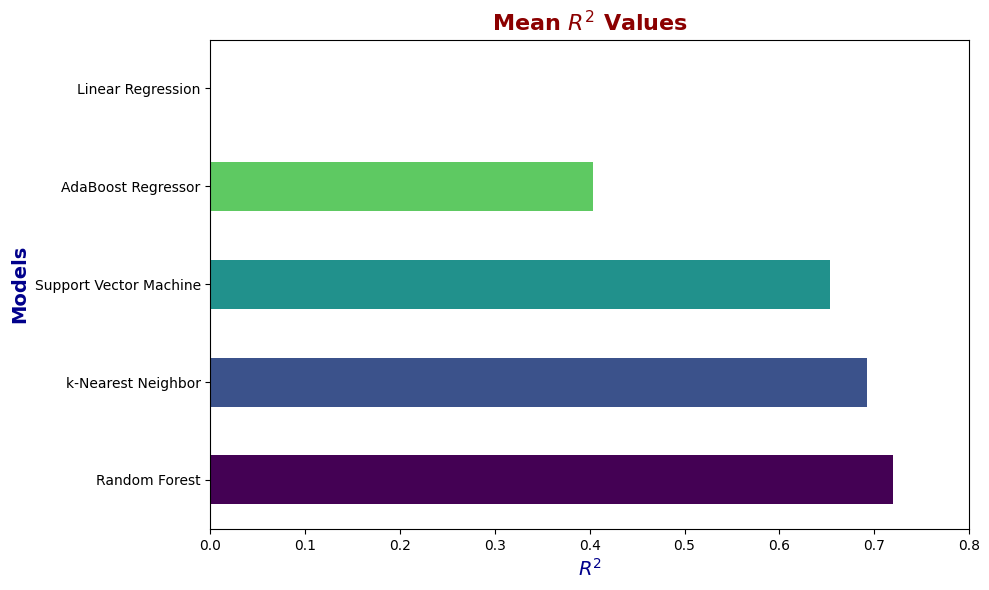

In [59]:
title_font = {"color" : "darkred", "weight" : "bold", "size" : 16}
axis_font = {"color" : "darkblue", "weight" : "bold", "size" : 14}

# Set up the figure
plt.figure(figsize=(10, 6))

# Sort the values
sorted_r2 = results_df['Mean R^2'].sort_values()

# Create colors based on sorted values
colors_r2 = plt.cm.viridis(np.linspace(0, 1, len(sorted_r2)))

# Plot Mean R2 values
sorted_r2 = results_df['Mean R^2'].sort_values(ascending=False)
sorted_r2.plot(kind='barh', color=colors_r2)
plt.title('Mean $R^2$ Values', fontdict=title_font)
plt.xlabel('$R^2$', fontdict=axis_font)
plt.ylabel('Models', fontdict=axis_font)
plt.xlim(0, 0.8)

#Save to pdf
plt.savefig('R^2_models.pdf', bbox_inches = 'tight')

# Adjust the layout
plt.tight_layout()
plt.show()

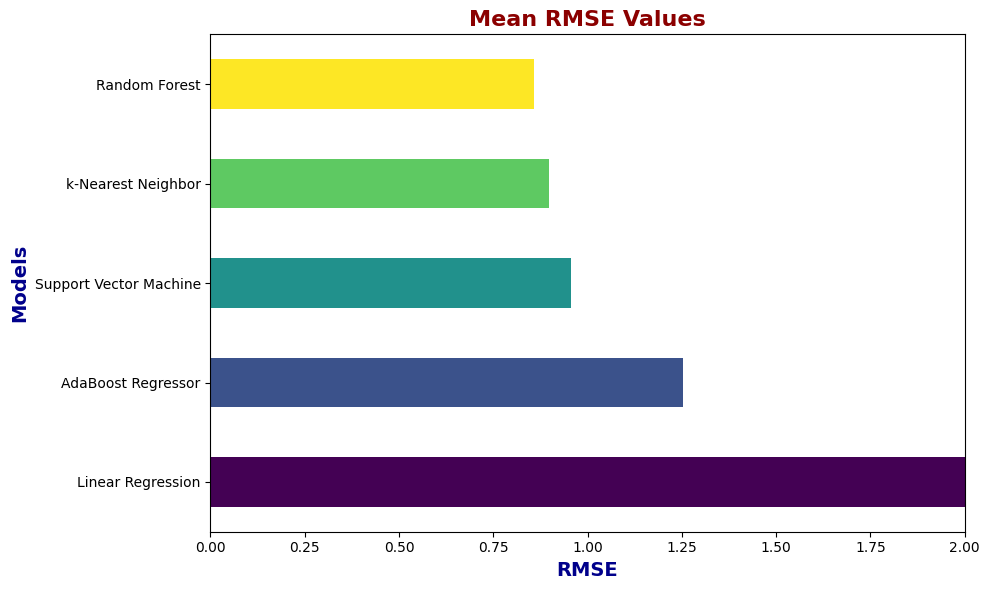

In [60]:
# Set up the figure
plt.figure(figsize = (10, 6))

# Sort the values
sorted_rmse = results_df['Mean RMSE'].sort_values()

# Create colors based on sorted values
colors_rmse = plt.cm.viridis(np.linspace(0, 1, len(sorted_rmse)))

# Plot Mean RMSE values
sorted_rmse = results_df['Mean RMSE'].sort_values(ascending=False)
sorted_rmse.plot(kind='barh', color=colors_rmse)
plt.title('Mean RMSE Values', fontdict=title_font)
plt.xlabel('RMSE', fontdict=axis_font)
plt.ylabel('Models', fontdict=axis_font)
plt.xlim(0,2)

#Save to pdf
plt.savefig('RMSE_models.pdf', bbox_inches = 'tight')

# Adjust the layout
plt.tight_layout()
plt.show()

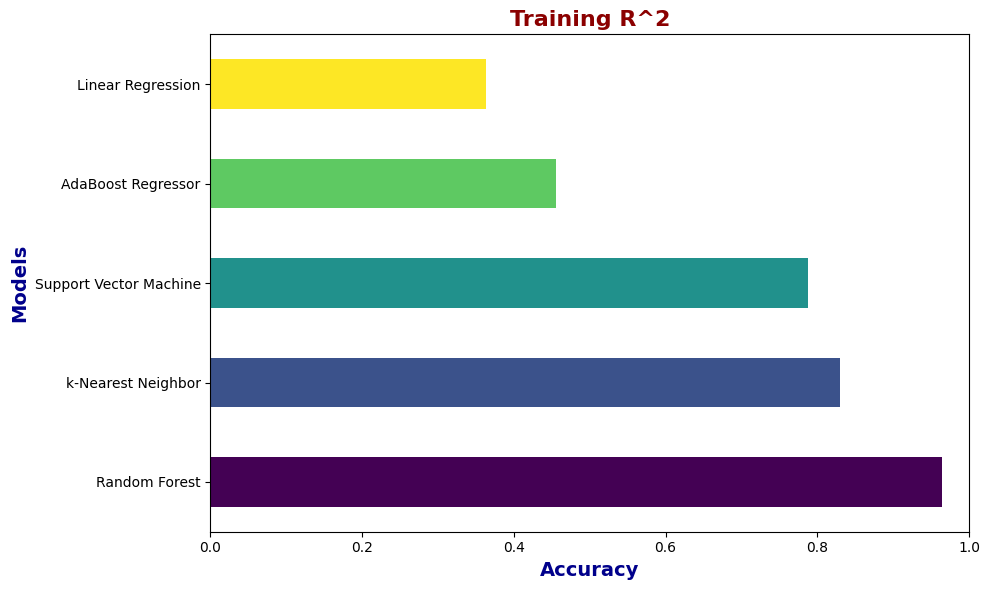

In [61]:
# Set up the figure
plt.figure(figsize=(10, 6))

# Sort the values
sorted_acc = results_df['Training R^2'].sort_values()

# Create colors based on sorted values
colors_acc = plt.cm.viridis(np.linspace(0, 1, len(sorted_acc)))

# Plot Training R^2
sorted_accuracy = results_df['Training R^2'].sort_values(ascending=False)
sorted_accuracy.plot(kind='barh', color=colors_acc)
plt.title('Training R^2', fontdict=title_font)
plt.xlabel('Accuracy', fontdict=axis_font)
plt.ylabel('Models', fontdict=axis_font)
plt.xlim(0, 1)

#Save to pdf
plt.savefig('Training_R2.pdf', bbox_inches = 'tight')

# Adjust the layout
plt.tight_layout()
plt.show()

## Feature Importance

In [62]:
# Extract feature importances
feature_importances = models['Random Forest'].feature_importances_

# Create a DataFrame for the feature importances
features_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
sorted_features_df = features_df.sort_values(by='Importance', ascending=False)
sorted_features_df[:20]

,Feature,Importance
155,EState_VSA5,0.107566
87,SdssC,0.043955
10,ATSC5d,0.037268
7,ATSC5dv,0.036239
32,BCUTs-1h,0.029849
136,PEOE_VSA8,0.027750
135,PEOE_VSA7,0.027740
26,GATS1s,0.026057
88,SaasC,0.024332
126,ETA_dEpsilon_D,0.020362


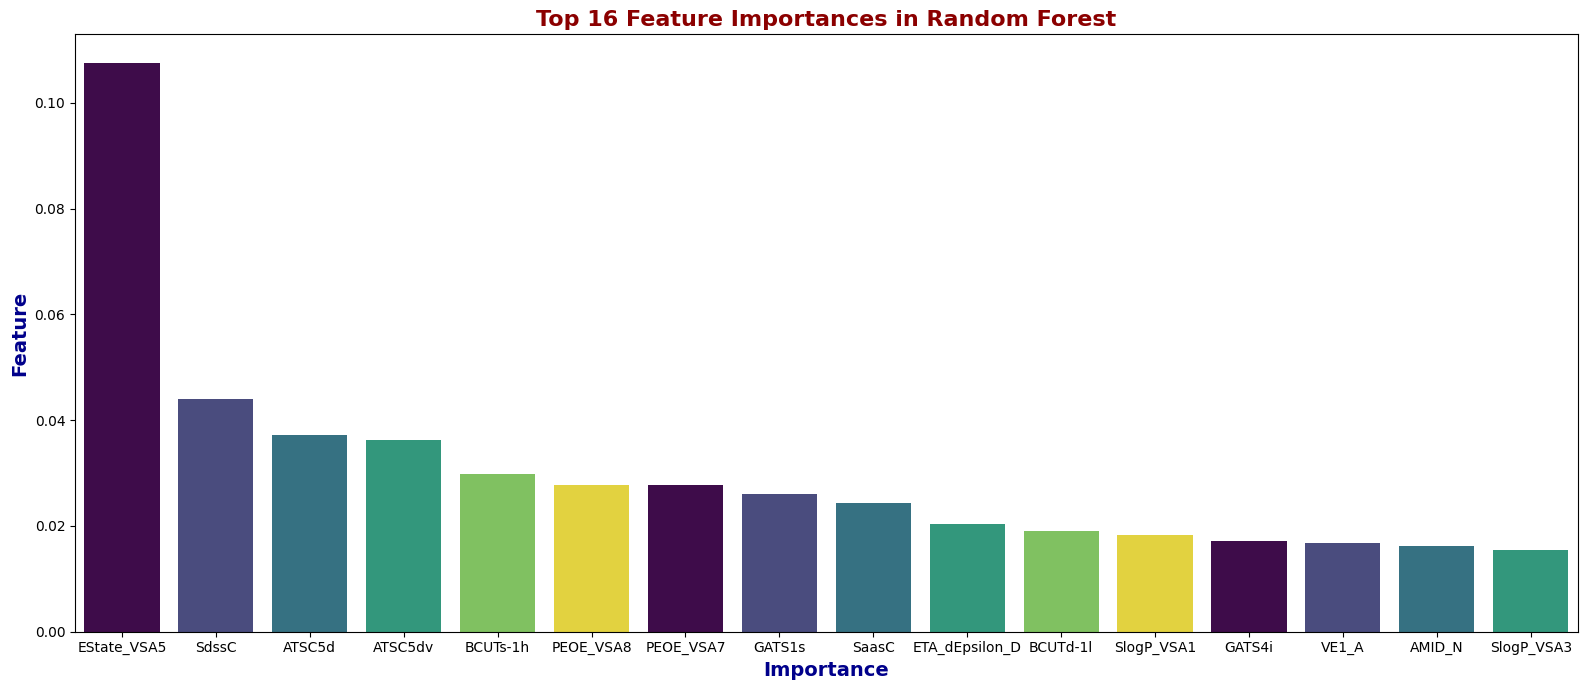

In [63]:
# Set the plot
plt.figure(figsize=(16, 7))

# Set the color
color = plt.cm.viridis(np.linspace(0, 1, 6))

# Plot the top 6 features using seaborn
sns.barplot(y='Importance', x='Feature', data=sorted_features_df.iloc[:16], palette=color)

plt.title('Top 16 Feature Importances in Random Forest', fontdict=title_font)
plt.xlabel('Importance', fontdict=axis_font)
plt.ylabel('Feature',fontdict=axis_font)
plt.xticks

#Save to pdf
plt.savefig('Features_importance.pdf', bbox_inches = 'tight')

# Adjust the layout
plt.tight_layout()
plt.show()

## Predictions

In [64]:
scaled_test_id

,nAcid,nBase,VE1_A,nSpiro,nBridgehead,nB,AATS4i,ATSC5dv,ATSC6dv,ATSC8dv,...,n9FAHRing,JGI2,JGI3,JGI4,JGI5,JGI6,JGI7,JGI8,JGI9,JGI10
molecule_chembl_id,,,,,,,,,,,,,,,,,,,,,
CHEMBL4469239,-0.101222,-1.119953,-0.614133,-0.186348,-0.201266,0.0,-0.371362,-1.062977,-0.449035,0.392652,...,-0.237239,-0.411964,-0.311435,-1.105279,-1.194229,-0.929048,-0.756143,-0.964918,-0.360069,0.189464
CHEMBL4780352,-0.101222,0.254519,0.341757,-0.186348,-0.201266,0.0,-0.789470,1.461434,1.509527,0.704097,...,-0.237239,0.236388,0.055988,-0.209168,1.130219,0.225625,-0.476976,0.692281,-0.144194,0.082242
CHEMBL4467284,-0.101222,-1.119953,-0.633209,-0.186348,-0.201266,0.0,-0.251088,-0.877943,-0.378276,0.012716,...,-0.237239,-0.553867,-0.424719,-1.232577,-1.289378,-1.058555,-0.667804,-0.843263,-0.840306,-0.780810
CHEMBL3585776,-0.101222,-1.119953,0.204064,-0.186348,-0.201266,0.0,0.259961,0.845965,-0.121190,0.598306,...,-0.237239,0.211195,0.495218,-0.180903,1.001692,0.405687,1.011342,0.094045,0.617024,0.128128
CHEMBL3585775,-0.101222,-1.119953,-0.037048,-0.186348,-0.201266,0.0,0.198412,-0.303865,1.589814,-0.788255,...,-0.237239,0.211195,1.215229,-0.532039,0.964370,0.561990,0.595325,0.008452,0.120004,0.270884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CHEMBL4763394,-0.101222,-1.119953,1.287092,-0.186348,-0.201266,0.0,0.133096,0.372649,0.205101,1.098669,...,-0.237239,0.201582,0.409322,0.270581,-0.252928,0.508592,-0.263863,0.340998,0.397929,0.780116
CHEMBL335439,-0.101222,0.254519,-1.004270,-0.186348,-0.201266,0.0,1.313693,-0.671172,0.238354,0.408040,...,-0.237239,1.728596,1.747869,0.652176,2.352194,0.295078,4.653296,-0.653066,-2.121659,-1.870455
CHEMBL1276594,-0.101222,-1.119953,0.204940,-0.186348,-0.201266,0.0,1.295236,-0.439031,-1.351165,0.672775,...,-0.237239,-1.847769,0.881750,-0.997218,-0.950815,-0.462675,-2.614981,-1.409554,-0.478449,-1.870455


In [65]:
scaled_pic50_test_df_id

,pIC50
molecule_chembl_id,
CHEMBL4469239,5.096115
CHEMBL4780352,5.096115
CHEMBL4467284,5.096115
CHEMBL3585776,2.804441
CHEMBL3585775,2.804441
...,...
CHEMBL4763394,-2.321545
CHEMBL335439,-2.406269
CHEMBL1276594,-2.449278


In [66]:
y_pred = models['Random Forest'].predict(scaled_test_id)

In [67]:
y_pred

array([ 2.54994618,  0.39692068,  2.10095434, ..., -0.77781677,
       -1.00444911, -0.43122992])

In [68]:
# Reshape y_pred for inverse transformation
y_pred_reshaped = y_pred.reshape(-1, 1)

# Reverse the scaling
reversed_y_pred = pic50_scaler.inverse_transform(y_pred_reshaped)
reversed_y_pred

array([[ 1.15683505],
       [-2.34747243],
       [ 0.42604694],
       ...,
       [-4.25949865],
       [-4.62837   ],
       [-3.69538695]])

### RMSE and R^2<a name = 25></a>

In [69]:
# Extract actual experimental results
actual_values = test['pIC50']

# Calculate metrics
rmse_rf = mean_squared_error(actual_values, reversed_y_pred, squared=False)
r2_rf = r2_score(actual_values, reversed_y_pred)

rmse_rf, r2_rf

(1.2944474464601292, 0.2944484354102692)

### Scatter Plot<a name = 26></a>

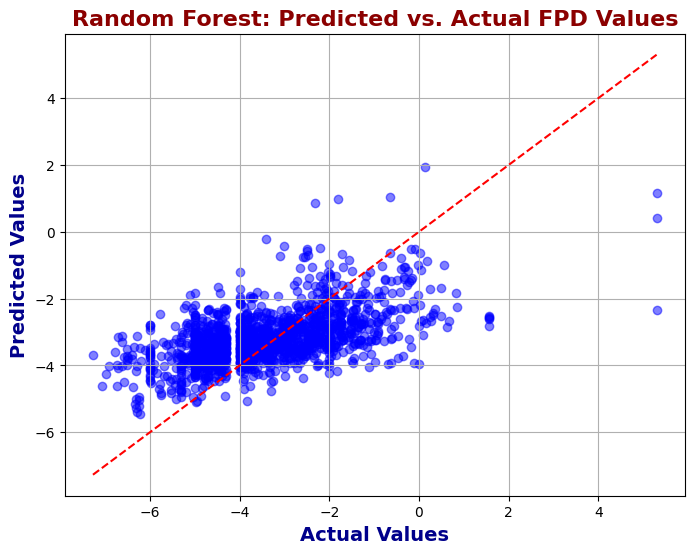

In [70]:
# Scatter plot of predicted vs. actual values
plt.figure(figsize=(8, 6))
plt.scatter(actual_values, reversed_y_pred, alpha=0.5, color='blue')
plt.plot([min(actual_values), max(actual_values)], [min(actual_values), max(actual_values)], color='red', linestyle='--')
plt.title('Random Forest: Predicted vs. Actual FPD Values', fontdict=title_font)
plt.xlabel('Actual Values', fontdict=axis_font)
plt.ylabel('Predicted Values', fontdict=axis_font)
plt.grid(True)
plt.savefig("RF_predicted_vs_actual.pdf", bbox_inches='tight')
plt.show()

### Residual Plot<a name = 27></a>

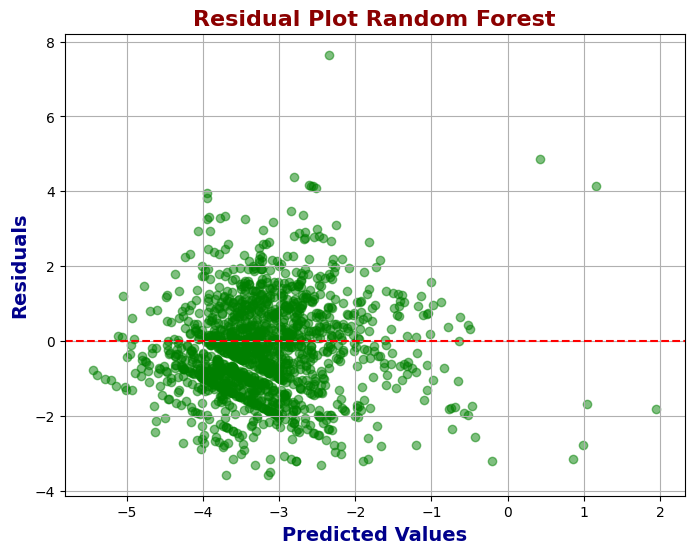

In [71]:
# Residual plot
residuals = actual_values - reversed_y_pred.flatten()
plt.figure(figsize=(8, 6))
plt.scatter(reversed_y_pred, residuals, alpha=0.5, color='green')
plt.title('Residual Plot Random Forest', fontdict=title_font)
plt.xlabel('Predicted Values', fontdict=axis_font)
plt.ylabel('Residuals', fontdict=axis_font)
plt.axhline(y=0, color='red', linestyle='--')
plt.grid(True)
plt.savefig("RF_residuals.pdf", bbox_inches='tight')
plt.show()

### Absolute Difference<a name = 28></a>

In [72]:
# Create a DataFrame with actual and predicted values
comparison_df_rf = pd.DataFrame({
    'Actual Values': actual_values,
    'Predicted Values': reversed_y_pred.flatten(),
    'Absolute Difference': abs(actual_values - reversed_y_pred.flatten())
})

# Display the first few rows of the DataFrame
print(comparison_df_rf.head())

                    Actual Values  Predicted Values  Absolute Difference
molecule_chembl_id                                                      
CHEMBL4469239            5.301030          1.156835             4.144195
CHEMBL4780352            5.301030         -2.347472             7.648502
CHEMBL4467284            5.301030          0.426047             4.874983
CHEMBL3585776            1.571056         -2.605062             4.176118
CHEMBL3585775            1.571056         -2.806906             4.377962


In [73]:
# Compute summary statistics on the "Difference" column
difference_statistics = comparison_df_rf["Absolute Difference"].describe()

difference_statistics

count    1510.000000
mean        1.013243
std         0.805831
min         0.000295
25%         0.371473
50%         0.857527
75%         1.433122
max         7.648502
Name: Absolute Difference, dtype: float64

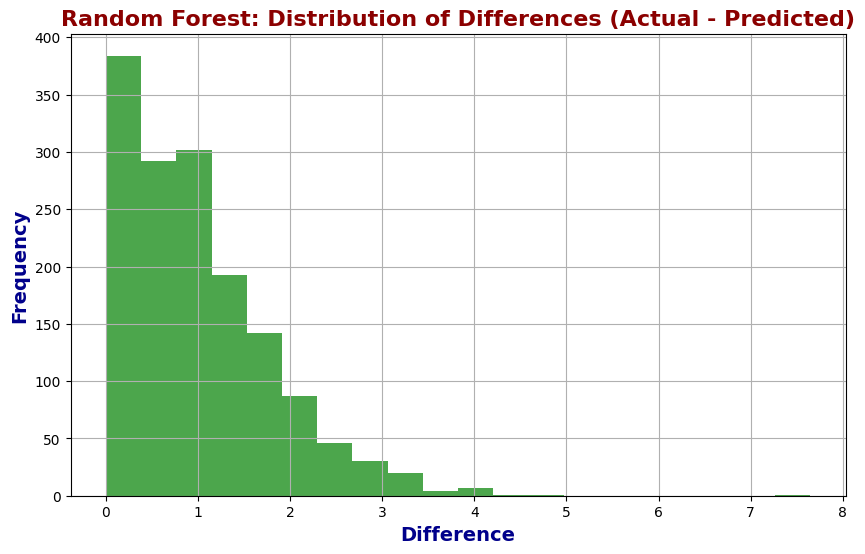

In [74]:
# Histogram of differences
plt.figure(figsize=(10, 6))
plt.hist(comparison_df_rf["Absolute Difference"], bins=20, color='green', alpha=0.7)
plt.title('Random Forest: Distribution of Differences (Actual - Predicted)', fontdict=title_font)
plt.xlabel('Difference', fontdict=axis_font)
plt.ylabel('Frequency', fontdict=axis_font)
plt.grid(True)
plt.savefig("RF_difference.pdf", bbox_inches='tight')

plt.show()

In [75]:
comparison_df_rf

,Actual Values,Predicted Values,Absolute Difference
molecule_chembl_id,,,
CHEMBL4469239,5.301030,1.156835,4.144195
CHEMBL4780352,5.301030,-2.347472,7.648502
CHEMBL4467284,5.301030,0.426047,4.874983
CHEMBL3585776,1.571056,-2.605062,4.176118
CHEMBL3585775,1.571056,-2.806906,4.377962
...,...,...,...
CHEMBL4763394,-6.772102,-3.607741,3.164361
CHEMBL335439,-6.910000,-4.020569,2.889431
CHEMBL1276594,-6.980003,-4.259499,2.720504


In [76]:
test_molecules_df = pd.concat([test['curated_smiles'], comparison_df_rf], axis=1)

In [77]:
test_molecules_df

,curated_smiles,Actual Values,Predicted Values,Absolute Difference
molecule_chembl_id,,,,
CHEMBL4469239,S=C(CCCCCNc1c2c(nc3ccccc13)CCCC2)NCCc1c[nH]c2c...,5.301030,1.156835,4.144195
CHEMBL4780352,COc1cc2c(cc1OC)C(=O)C(=Cc1ccc(OCCCCN[N+]3(C)CC...,5.301030,-2.347472,7.648502
CHEMBL4467284,S=C(CCCCCCCNc1c2c(nc3ccccc13)CCCC2)NCCc1c[nH]c...,5.301030,0.426047,4.874983
CHEMBL3585776,COc1ccc(C(C)NS(=O)(=O)NC(=O)OCc2ccccc2)cc1,1.571056,-2.605062,4.176118
CHEMBL3585775,COc1ccccc1C(C)NS(=O)(=O)NC(=O)OCc1ccccc1,1.571056,-2.806906,4.377962
...,...,...,...,...
CHEMBL4763394,ON=Cc1cc(Cl)cc(CNc2ccc(N3CCOCC3)c(F)c2)c1O,-6.772102,-3.607741,3.164361
CHEMBL335439,C[N+]1(C)CCOC(O)(c2ccc(Cl)cc2)C1,-6.910000,-4.020569,2.889431
CHEMBL1276594,O=P(NN1CCOCC1)(NN1CCOCC1)Oc1ccccc1,-6.980003,-4.259499,2.720504


,curated_smiles,Actual Values,Predicted Values,Absolute Difference,ROMol
molecule_chembl_id,,,,,
CHEMBL4469239,S=C(CCCCCNc1c2c(nc3ccccc13)CCCC2)NCCc1c[nH]c2c...,5.301030,1.156835,4.144195,
CHEMBL4780352,COc1cc2c(cc1OC)C(=O)C(=Cc1ccc(OCCCCN[N+]3(C)CC...,5.301030,-2.347472,7.648502,
CHEMBL4467284,S=C(CCCCCCCNc1c2c(nc3ccccc13)CCCC2)NCCc1c[nH]c...,5.301030,0.426047,4.874983,
CHEMBL3585776,COc1ccc(C(C)NS(=O)(=O)NC(=O)OCc2ccccc2)cc1,1.571056,-2.605062,4.176118,
CHEMBL3585775,COc1ccccc1C(C)NS(=O)(=O)NC(=O)OCc1ccccc1,1.571056,-2.806906,4.377962,
...,...,...,...,...,...
CHEMBL4763394,ON=Cc1cc(Cl)cc(CNc2ccc(N3CCOCC3)c(F)c2)c1O,-6.772102,-3.607741,3.164361,
CHEMBL335439,C[N+]1(C)CCOC(O)(c2ccc(Cl)cc2)C1,-6.910000,-4.020569,2.889431,
CHEMBL1276594,O=P(NN1CCOCC1)(NN1CCOCC1)Oc1ccccc1,-6.980003,-4.259499,2.720504,

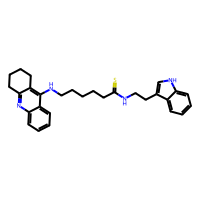
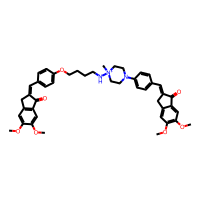
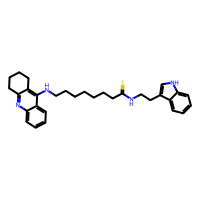
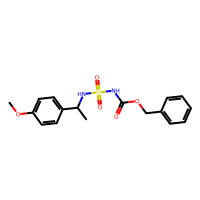
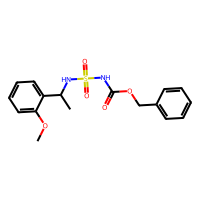
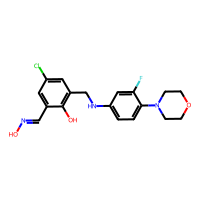
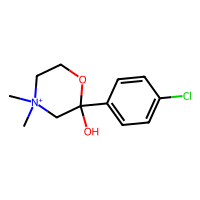
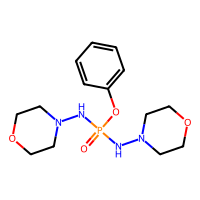
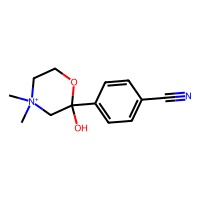
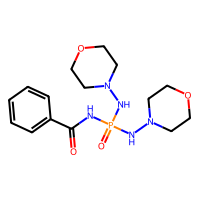

In [78]:
# using pandastools to create molecule from smiles within the dataframe
PandasTools.AddMoleculeColumnToFrame(test_molecules_df, smilesCol="curated_smiles")
test_molecules_df

/usr/local/lib/python3.10/dist-packages/rdkit/Chem/Draw/IPythonConsole.py:258: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


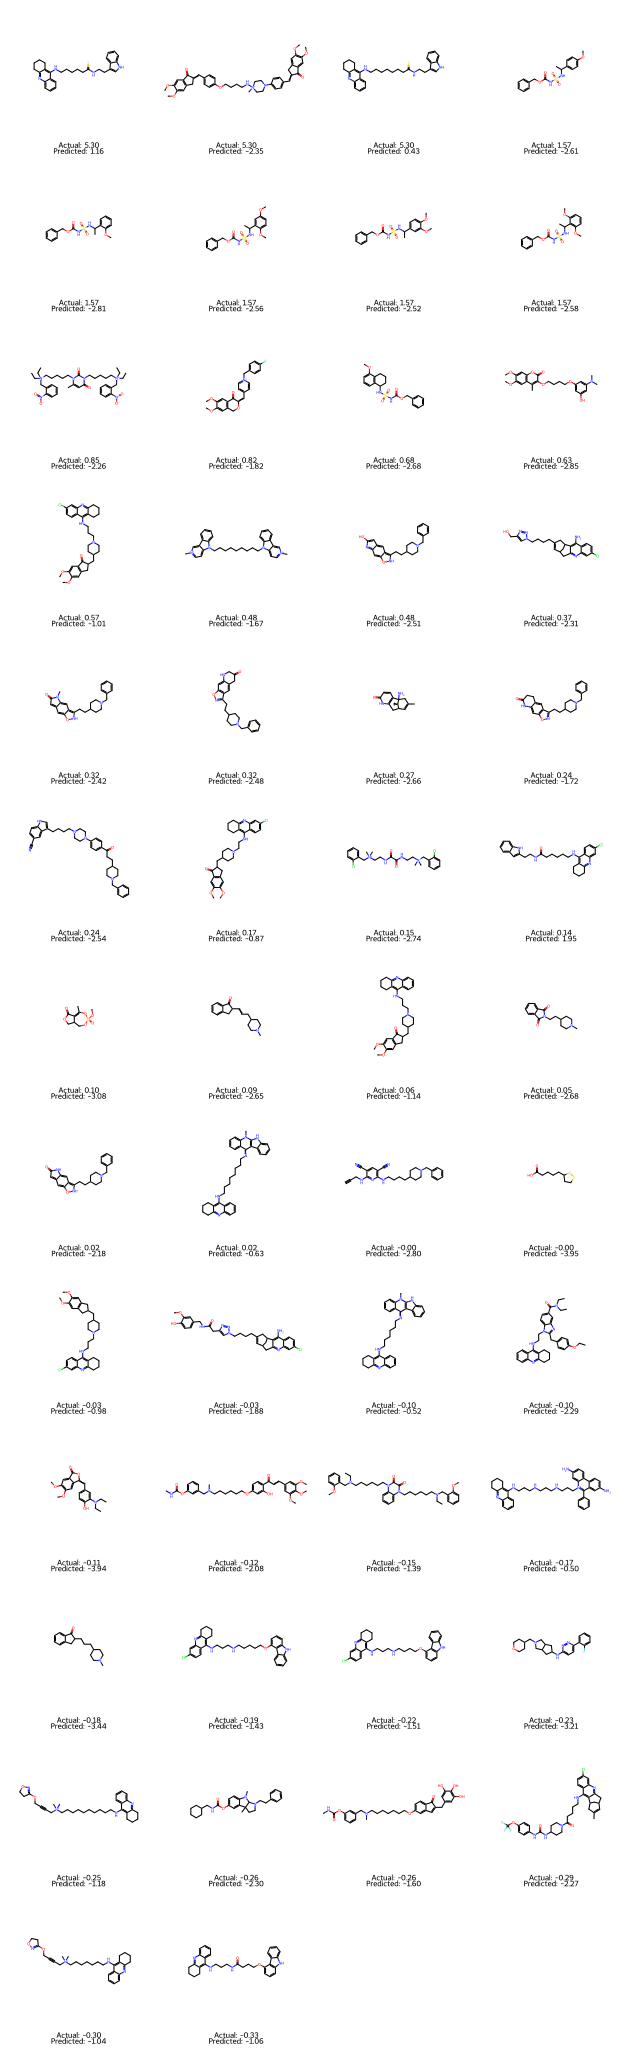

In [79]:
from rdkit.Chem import Draw
import cairosvg

# Step 1: Create the legends list
legends = test_molecules_df.apply(lambda row: f"Actual: {row['Actual Values']:.2f}\nPredicted: {row['Predicted Values']:.2f}", axis=1).tolist()

# Step 2: Generate the SVG image
img_svg = Draw.MolsToGridImage(test['Molecule'],
                               subImgSize=(300,300),
                               molsPerRow=4,
                               legends=legends,
                               useSVG=True)


# Save the SVG image to a file
svg_filename = "Molecules_predicted_vs_Observed.svg"
with open(svg_filename, "w") as f:
    f.write(img_svg.data)


# Convert the SVG to PDF
pdf_filename = svg_filename.replace(".svg", ".pdf")
cairosvg.svg2pdf(url=svg_filename, write_to=pdf_filename)

# Display the generated image
img_svg

## 7. Conclusions

The prediction of the ML model is very poor in the majority of the molecules. One hypotesis is due to the splitting of the test and train dataset based on Murcko scaffold and Butina clustering, which increases the difficulty for the algorithm to predict the outcome. This is because similar molecules where placed either in the test or the train set.

Overall, the objective of this project was to illustrate and understand how the spliting of the data has a profound effect on the ML algorithm and subsequent prediction. The slplitting will be re-analyzed as well as the features used for the design of the ML model.

Perspectives: The model will have to be optimized in order to be used as a predictive model.

